# SVR

In [1]:
import scipy.io as sio
import pandas as pd
from tqdm import tnrange, tqdm_notebook
from sklearn.preprocessing import maxabs_scale, minmax_scale
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso, ElasticNet
import itertools
warnings.filterwarnings('ignore')
sns.set(style='whitegrid',palette='cividis')

In [30]:
rdata_raw = sio.loadmat('D:/ML/data/Data_noV0/rData.mat')['rData_all'].T
cdata_raw = sio.loadmat('D:/ML/data/Data_noV0/cData.mat')['cData_all'].T
xdata_raw = sio.loadmat('D:/ML/data/Data_noV0/xData.mat')['xData_all'].T
pdata_raw = sio.loadmat('D:/ML/data/Data_noV0/pData.mat')['pData_all'].T
# data_raw = np.hstack((rdata_raw,cdata_raw,xdata_raw,pdata_raw))
# weight = [15,14,14,14,14,14,14,14,14,14] # 10-fold validation proportion

# pos = sio.loadmat('D:/ML/data/Data_noV0/posPANSS.mat')['pos_all'].T
# neg = sio.loadmat('D:/ML/data/Data_noV0/negPANSS.mat')['neg_all'].T
# gen = sio.loadmat('D:/ML/data/Data_noV0/genPANSS.mat')['gen_all'].T
# tot = sio.loadmat('D:/ML/data/Data_noV0/totPANSS.mat')['tot_all'].T
cog = sio.loadmat('D:/ML/data/Data_noV0/cogPANSS.mat')['PANSS_cog_all'].T

# # No V0
# rdata_raw = sio.loadmat('Data_noV0/rData.mat')['rData_all'].T
# cdata_raw = sio.loadmat('Data_noV0/cData.mat')['cData_all'].T
# xdata_raw = sio.loadmat('Data_noV0/xData.mat')['xData_all'].T
# pdata_raw = sio.loadmat('Data_noV0/pData.mat')['pData_all'].T
# cog = sio.loadmat('Data_noV0/cogPANSS.mat')['PANSS_cog_all'].T
# tot = sio.loadmat('Data_noV0/totPANSS.mat')['tot_all'].T

In [31]:
# Normalization
rdata_maxabs = maxabs_scale(rdata_raw,axis=0)
cdata_maxabs = maxabs_scale(cdata_raw,axis=0)
pdata_maxabs = maxabs_scale(pdata_raw,axis=0)
xdata_maxabs = maxabs_scale(xdata_raw,axis=0)
data_maxabs = [rdata_maxabs,cdata_maxabs,xdata_maxabs,pdata_maxabs]

In [32]:
# score normalization
cog_app = np.vstack((cog,[10],[52]))
# score = np.hstack((pos,neg,gen,tot))
cog_minmax = minmax_scale(cog_app,axis=0)
cog_maxabs = maxabs_scale(cog_app,axis=0)
cog_norm = cog_minmax[:-2]

In [46]:
# score normalization
tot_app = np.vstack((tot,[30],[170]))
# score = np.hstack((pos,neg,gen,tot))
tot_minmax = minmax_scale(cog_app,axis=0)
tot_maxabs = maxabs_scale(cog_app,axis=0)
tot_norm = tot_minmax[:-2]

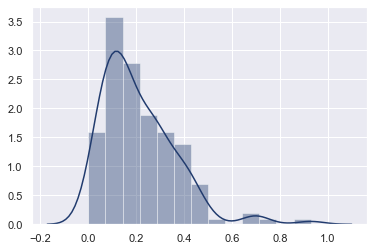

In [40]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(cog_norm)

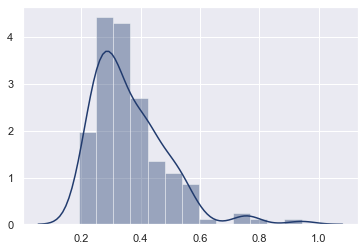

In [41]:
import seaborn as sns

sns.set_style('darkgrid')
sns.distplot(tot_norm)

In [6]:
def lassoWriter(path, feature, result, score, best_r2, state):
    f = open(path, 'a')
    f.write('========================================\n')
    f.write('=====Exp:'+str(datetime.now())+'=====\n')
    f.write('========================================\n')
    f.write('Kernel: Linear, State: '+str(state)+'\n')
    f.write('Best R2: '+str(round(best_r2[1],8))+'\n')
    f.write('at Alpha: '+str(round(best_r2[0],7)))
    f.write('\n----------------------------------------\n')
    f.write('Selected Features '+str(len(feature))+':\n')
    for i in range(int(len(feature)/25)):
        for j in range(25):
            f.write(str(feature[i*25+j])+',')
        f.write('\n')
    for i in range(len(feature)%25):
        f.write(str(feature[i-len(feature)%25])+',')
    f.write('\n----------------------------------------\n')
    f.write('Predict and Truth at Best Alpha and Fold:\n')
    for item in result[0]:
        f.write(str(round(item,2))+',')
    f.write('\n')
    for item in result[1]:
        f.write(str(item)+'.00,')
    f.write('\n----------------------------------------\n')
    f.write('MSE and R2 at Best Alpha:\n')
    for item in score[0]:
        f.write(str(round(item,5))+',')
    f.write('\n')
    for item in score[1]:
        f.write(str(round(item,5))+',')
    f.write('\n-----------------END--------------------\n\n\n')

In [7]:
def cal_score(data,data_max,data_min):
    return np.dot(data,(data_max - data_min)) + data_min

In [8]:
def create_alpha(ll,ul,step):
    ilist=[]
    ilist_exp = np.linspace(ll,ul,step)
    ilist_raw = [[10**(item),5.0*10**(item)] for item in ilist_exp]
    [ilist.extend(i) for i in ilist_raw]
    return ilist

## Single kernel Lasso

In [136]:
def lassoCD(X, y, ll, ul, step, state, score_min, score_max):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    feature = []
    score = []
    metric = []
    m_mse = []
    m_r2 = []
    ilist = np.linspace(ll,ul,step)
    pbar = tnrange(step*10, desc='loop')
    for i in ilist: # search best parameter
        mse = []
        r2 = []
        fea = []
        sco_pred = []
        sco_true = []
        for train_index, test_index in kf.split(X):
            y_train, y_test_raw = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            
            clf = Lasso(alpha=i)
            clf.fit(X_train_tmp, np.ravel(y_train))
            fea_idx = [i for i,x in enumerate(clf.coef_) if x>0]
            X_train = X_train_tmp[:,fea_idx]
            X_test = X_test_tmp[:,fea_idx]
            y_test_raw = list(list(zip(*y_test_raw))[0])

            svr = SVR(kernel='linear')
            
            svr.fit(X_train, np.ravel(y_train))
            y_test_pred_raw = svr.predict(X_test)
            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
            y_test = cal_score(y_test_raw,score_max,score_min)
            mse.append(mean_squared_error(y_test, y_test_pred))
            r2.append(r2_score(y_test, y_test_pred))
            fea.append(fea_idx)
            sco_pred.append(list(y_test_pred))
            sco_true.append(list(y_test))
            pbar.update(1)
        feature.append(fea)
        score.append((sco_pred, sco_true))
        metric.append((mse,r2))
        m_mse.append(sum(mse)/10)  # mean mse trace for all alpha
        m_r2.append(sum(r2)/10)    # mean r2 trace for all alpha
    
    a = m_r2.index(max(m_r2))
    feature_fd = [len(feature[a][i]) for i in range(10)]
    num_feature = int(np.mean(feature_fd))
    df = {'max_r2': m_r2[a], 'best_alpha': ilist[a], 'num_features': num_feature}
    pbar.close()
#     plt.figure()
#     plt.plot(ilist,m_r2)
#     plt.xlabel('$alpha$')
#     plt.ylabel('$R^2$')
    print(m_r2)
    print('best r2_score=',m_r2[a],', corresponding alpha=', ilist[a])
    print('number of selected features:',num_feature)
    return df, feature[a], score[a], metric[a]

In [137]:
X = cdata_maxabs
y = cog_norm
ll = 0.0060
ul = 0.00695
step = 20
print(np.linspace(ll,ul,step))
state = 73
score_min = 10
score_max = 52
result, feature, score, metric = lassoCD(X, y, ll, ul, step, state, score_min, score_max)

[0.006   0.00605 0.0061  0.00615 0.0062  0.00625 0.0063  0.00635 0.0064
 0.00645 0.0065  0.00655 0.0066  0.00665 0.0067  0.00675 0.0068  0.00685
 0.0069  0.00695]



[-0.18495198271520696, -0.18194558146825024, -0.18213185961687745, -0.1744303145736038, -0.17390004974950413, -0.16857742687415408, -0.16104173298996272, -0.1638618803564409, -0.15767257229929682, -0.15158911199102368, -0.15102679223914764, -0.13420695733703916, -0.1157558846812436, -0.1121417704257593, -0.1121417704257593, -0.1121417704257593, -0.1121417704257593, -0.10559334930073672, -0.10936625253766752, -0.12211460452421323]
best r2_score= -0.10559334930073672 , corresponding alpha= 0.006849999999999999
number of selected features: 4


In [153]:
X = pdata_maxabs
y = cog_norm
ll = 1e-12
ul = 1e-8
step = 10
state = 73
score_min = 10
score_max = 52
result, feature, score, metric = lassoCD(X, y, ll, ul, step, state, score_min, score_max)


[-0.07570565013286902]
best r2_score= -0.07570565013286902 , corresponding alpha= 4.445e-09
number of selected features: 9870


In [ ]:
# 4.445000000000001e-09

## Elastic Net

In [154]:
def elastic_net(X, y, ll1, ul1, step1, ll2, ul2, step2, state, score_min, score_max):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    feature = []
    score = []
    metric = []
    m_mse = []
    m_r2 = []
    pbar = tnrange(step1*step2*10, desc='loop')
    inp = [list(np.linspace(ll1,ul1,step1)), list(np.linspace(ll2,ul2,step2))]
    g = [i for i in itertools.product(*inp)]
    ilist = []
    for k in range(len(g)):
        mse = []
        r2 = []
        fea = []
        sco_pred = []
        sco_true = []
        for train_index, test_index in kf.split(X):
            y_train, y_test_raw = y[train_index], y[test_index]
            X_train_tmp, X_test_tmp = X[train_index], X[test_index]
            regr = ElasticNet(random_state=state,alpha=g[k][0],l1_ratio=g[k][1])
            regr.fit(X_train_tmp, np.ravel(y_train))
            fea_idx = [i for i,x in enumerate(regr.coef_) if x>0]
            X_train = X_train_tmp[:,fea_idx]
            X_test = X_test_tmp[:,fea_idx]
            y_test_raw = list(list(zip(*y_test_raw))[0])

            svr = SVR(kernel='linear')
            
            svr.fit(X_train, np.ravel(y_train))
            y_test_pred_raw = svr.predict(X_test)
            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
            y_test = cal_score(y_test_raw,score_max,score_min)
            mse.append(mean_squared_error(y_test, y_test_pred))
            r2.append(r2_score(y_test, y_test_pred))
            fea.append(fea_idx)
            sco_pred.append(list(y_test_pred))
            sco_true.append(list(y_test))
            pbar.update(1)
        feature.append(fea)
        score.append((sco_pred, sco_true))
        metric.append((mse,r2))
        m_mse.append(sum(mse)/10)  # mean mse trace for all alpha
        m_r2.append(sum(r2)/10)    # mean r2 trace for all alpha
        ilist.append(g[k])
    a = m_r2.index(max(m_r2))
    feature_fd = [len(feature[a][i]) for i in range(10)]
    num_feature = int(np.mean(feature_fd))
    df = {'max_r2': m_r2[a], 'best_alpha': ilist[a], 'num_features': num_feature}
    pbar.close()
    print(m_r2)
#     plt.figure()
#     plt.scatter(np.log10(np.array(g)[:,0]),np.array(g)[:,1],c=m_r2,marker='.',cmap='copper_r')
#     plt.xlabel('$alpha$')
#     plt.ylabel('$L1 ratio$')
#     print(np.array(ilist),m_r2)
#     plt.axis([ll1-(ul1-ll1)*0.05,ul1+(ul1-ll1)*0.05,ll2-(ul2-ll2)*0.05,ul2+(ul2-ll2)*0.05])
    print('best r2_score=',m_r2[a],', corresponding alpha=', ilist[a])
    print('number of selected features:',num_feature)
    return df, feature[a], score[a], metric[a]

In [ ]:
X = cdata_maxabs
y = cog_norm
ll1 = 0.00685
ul1 = 0.00690
step1 = 6
ll2 = 0.996
ul2 = 0.9979
step2 = 20
state = 73
score_min = 10
score_max = 52
result_row, feature, score, metric = elastic_net(X, y, ll1, ul1, step1, ll2, ul2, step2, state, score_min, score_max)

In [155]:
X = pdata_maxabs
y = cog_norm
ll1 = 1e-12
ul1 = 1e-8
step1 = 10
ll2 = 0.90
ul2 = 0.99
step2 = 10
state = 73
score_min = 10
score_max = 52
result_row, feature, score, metric = elastic_net(X, y, ll1, ul1, step1, ll2, ul2, step2, state, score_min, score_max)


[-0.09166994743012336, -0.09239107011923788, -0.09220202644453791, -0.09161586097907494, -0.09115802931865997, -0.09093996783833502, -0.09152449905029493, -0.09149997036163195, -0.09160017138089796, -0.09081766444538536, -0.08061957209246161, -0.08115819275518192, -0.08156190616240734, -0.08245758714387455, -0.08218224041057955, -0.08228021052192672, -0.0808363127327799, -0.0806759715588509, -0.08164351394979505, -0.08197859195768659, -0.08172762477667406, -0.08178907684599723, -0.08267251697304213, -0.08363408798517186, -0.08415554664050692, -0.08400281759460676, -0.08410819246506497, -0.083968021458894, -0.08496004994382214, -0.08537454125004301, -0.08576182627888694, -0.08552322165176693, -0.08636352475650687, -0.08489367455045559, -0.08599488022006446, -0.08693135874479871, -0.08658202625755675, -0.08623308762726675, -0.08591172903095767, -0.08472775672995386, -0.07974907603603328, -0.07803512535201854, -0.07677867948050762, -0.07751309627965638, -0.07908632585897804, -0.078317193

## Single kernel RFE

In [58]:
def svmrfe(X, y, ll, ul, state, score_min, score_max):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    score = []
    R2 = []
    MSE = []
    fmap = []
    pbar = tnrange((ul-ll)*10, desc='loop')
    ilist = range(ll,ul)
    for train_index, test_index in kf.split(X):
        mse = []
        r2 = []
        sco = []
        y_train, y_test_raw = y[train_index], y[test_index]
        X_train_tmp, X_test_tmp = X[train_index], X[test_index]
        y_test_raw = list(list(zip(*y_test_raw))[0])
        svr_rfe = SVR(kernel='linear')
        rfe = RFE(estimator=svr_rfe, n_features_to_select=1, step=1)
        rfe.fit(X_train_tmp, y_train)
        importance = np.argsort(rfe.ranking_)
        fmap.append(importance)       
        for i in ilist:
            X_train = X_train_tmp[:,importance[:i]]
            X_test = X_test_tmp[:,importance[:i]]
            svr = SVR(kernel='linear')
            
            svr.fit(X_train, np.ravel(y_train))
            y_test_pred_raw = svr.predict(X_test)
            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
            y_test = cal_score(y_test_raw,score_max,score_min)
            mse.append(mean_squared_error(y_test, y_test_pred))
            r2.append(r2_score(y_test, y_test_pred))
            sco.append((list(y_test_pred), list(y_test)))
            pbar.update(1)
        R2.append(r2)
        score.append(sco)
        MSE.append(mse)
    m_r2 = np.mean(np.array(R2), axis = 0)
    idx = np.argmax(m_r2)
    metric = (np.array(R2)[:,idx], np.array(MSE)[:,idx])
    feature_fd = [list(fmap[i][:ilist[idx]]) for i in range(10)]
    score_pred = [score[i][idx][0] for i in range(10)]
    score_true = [score[i][idx][1] for i in range(10)]
    score_fd = [score_pred, score_true]
    df = {'max_r2': m_r2[idx],'num_features': ilist[idx]}
    pbar.close()
#     plt.figure()
#     plt.plot(ilist,m_r2)
#     plt.xlabel('$alpha$')
#     plt.ylabel('$R^2$')
    print('best r2_score=',m_r2[idx])
    print(m_r2)
    print('number of selected features:',ilist[idx])
    return df, feature_fd, score_fd, metric

In [61]:
# 67, 68
X = xdata_maxabs
y = cog_norm
ll = 1
ul = 70
state = 73
score_min = 10
score_max = 52
result, feature, score, metric = svmrfe(X, y, ll, ul, state, score_min, score_max)


best r2_score= 0.052713381239757016
[-0.05084852 -0.02830901 -0.02260405 -0.0223013  -0.02586626 -0.00487914
 -0.00251695  0.00073972  0.00737691  0.00986428 -0.01877231 -0.01817715
 -0.01683955 -0.01009342 -0.01286561 -0.01428959 -0.02933211 -0.01573994
 -0.0388949  -0.04382028 -0.0207787  -0.01061897 -0.00733123 -0.00705467
 -0.00056173 -0.00653098 -0.01265677 -0.01743922 -0.03212145 -0.0421346
 -0.03828265 -0.03633319 -0.03727447 -0.02910647 -0.03526716 -0.03660812
 -0.03372661 -0.02509868 -0.02887324 -0.02064554 -0.02153346 -0.01516739
 -0.02402201 -0.02315185 -0.01785853 -0.01565137 -0.01728943 -0.02183985
 -0.02212984 -0.01834617 -0.01183575 -0.00940259 -0.00761762 -0.00548826
 -0.0008091   0.00082538  0.01008987  0.01091864  0.00778699  0.01270861
  0.02853604  0.03349361  0.04033292  0.04005827  0.04612058  0.04507442
  0.05130498  0.05271338  0.0495899 ]
number of selected features: 68


In [62]:
# 1,2
X = rdata_maxabs
y = cog_norm
ll = 1
ul = 700
state = 73
score_min = 10
score_max = 52
result, feature, score, metric = svmrfe(X, y, ll, ul, state, score_min, score_max)


best r2_score= -0.03614344911158941
[-0.03614345 -0.04275318 -0.09118872 -0.0902038  -0.14740795 -0.18593806
 -0.24679604 -0.2732536  -0.37173928 -0.40496002 -0.47321878 -0.55807849
 -0.55364121 -0.62113279 -0.61167412 -0.5950677  -0.61702017 -0.57959691
 -0.60466342 -0.58137246 -0.59965087 -0.60104387 -0.63971702 -0.70798676
 -0.65776253 -0.68343475 -0.64334117 -0.63433579 -0.64266188 -0.62248191
 -0.59908083 -0.57889239 -0.56980663 -0.5795901  -0.57426584 -0.51845554
 -0.49050897 -0.47479167 -0.46557225 -0.46556209 -0.49836748 -0.5036902
 -0.50947717 -0.49973535 -0.46550218 -0.42624486 -0.43303873 -0.45094369
 -0.46580843 -0.44627715 -0.43919164 -0.48342295 -0.4891305  -0.49052873
 -0.45582055 -0.43553725 -0.41519135 -0.40565623 -0.37775667 -0.37296366
 -0.36984224 -0.35761818 -0.35641158 -0.33166744 -0.33467679 -0.32248031
 -0.31557588 -0.31854027 -0.30806906 -0.29493535 -0.3009932  -0.30859908
 -0.31319908 -0.31992672 -0.3316112  -0.33925668 -0.34405387 -0.33961679
 -0.31212639 -0

 -0.10420392 -0.10463596 -0.10475461]
number of selected features: 1


## Multi kernel

In [102]:
def single_lasso(x_train_tmp, y_train, ll, ul, step):
    fea_idx = []
    alpha = []
    ilist = np.linspace(ll,ul,step)
    for i in ilist:
        reg = Lasso(alpha=i)
        reg.fit(x_train_tmp, np.ravel(y_train))
        fea_idx.append([i for i,x in enumerate(reg.coef_) if x>0])
        alpha.append(i)
    return fea_idx, alpha

def single_elastic_net(x_train_tmp, y_train, ll1, ul1, step1, ll2, ul2, step2):
    fea_idx = []
    alpha = []
    pbar = tnrange(2*step1*step2*10, desc='loop')
    inp = [list(create_alpha(ll1,ul1,step1)), list(np.linspace(ll2,ul2,step2))]
    g = [i for i in itertools.product(*inp)]
    for k in range(len(g)):
        reg = ElasticNet(random_state=state,alpha=g[k][0],l1_ratio=g[k][1])
        reg.fit(x_train_tmp, np.ravel(y_train))
        fea_idx.append([i for i,x in enumerate(reg.coef_) if x>0])
        alpha.append(g[k])
    return fea_idx, alpha

def single_rfe(x, y, ln, un):
    svr_rfe = SVR(kernel='linear')
    rfe = RFE(estimator=svr_rfe, n_features_to_select=1, step=1)
    rfe.fit(x, y)
    importance = np.argsort(rfe.ranking_)
    fea_idx = []
    alpha = []
    for i in range(ln,un):
        fea_idx.append(importance[:i])
        alpha.append(i)
    return fea_idx, alpha

def select_features(X, y_train, train_index, l):
    rf, ra = single_rfe(X[0][train_index], y_train, l[0][0], l[0][1])
    cf, ca = single_lasso(X[1][train_index], y_train, l[1][0], l[1][1], l[1][2])
    xf, xa = single_rfe(X[2][train_index], y_train, l[2][0],l[2][1])
    pf, pa = single_lasso(X[3][train_index], y_train, l[3][0], l[3][1], l[3][2])
    return ra, rf, ca, cf, xa, xf, pa, pf

def gram(X1, X2, w):
    s= 0
    for i in range(4):
        X1[i]=np.array(X1[i])
        X2[i]=np.array(X2[i])
        s += w[i]*np.dot(X1[i], X2[i].T)
    return s

In [161]:
def multi(X, y, L, state, score_min, score_max):
    kf = KFold(n_splits=10,shuffle=True,random_state=state)
    multi_feature = []
    multi_score = []
    multi_r2 = []
    multi_mse = []
    w_grid = [list(np.linspace(0.0,1.0,11,dtype = np.float32))]
    W_grid = w_grid * len(L)
    W= [i for i in itertools.product(*W_grid) if np.sum(i)==1.0]
    pbar = tnrange(len(W), desc='loop')
    for w in W:
        feature = []
        metric = []
        R2 = []
        MSE = []
        score = []
        for train_index, test_index in kf.split(y):
            y_test_raw = np.ravel(y[test_index])
            y_train = np.ravel(y[train_index])
            svr = SVR(kernel='precomputed')
            ra, rf, ca, cf, xa, xf, pa, pf = select_features(X, y_train, train_index, L)
            mse = []
            r2 = []
            alpha = []
            fea = {}
            sco = {}
            for r in range(len(ra)):
                for c in range(len(ca)):
                    for x in range(len(xa)):
                        for p in range(len(pa)):
                            key = (ra[r],ca[c],xa[x],pa[p])
                            fea[key] = [list(rf[r]),cf[c],list(xf[x]),pf[p]]
                            X_train = [X[0][train_index][:,rf[r]], 
                                       X[1][train_index][:,cf[c]], 
                                        X[2][train_index][:,xf[x]], 
                                       X[3][train_index][:,pf[p]]]
                            X_test = [X[0][test_index][:,rf[r]], 
                                      X[1][test_index][:,cf[c]], 
                                        X[2][test_index][:,xf[x]], 
                                      X[3][test_index][:,pf[p]]]
                            kernel_train = gram(X_train, X_train, w)
                            svr.fit(kernel_train, np.ravel(y_train))
                            y_test_pred_raw = svr.predict(gram(X_test, X_train, w))
                            y_test_pred = cal_score(y_test_pred_raw,score_max,score_min)
                            y_test = cal_score(y_test_raw,score_max,score_min)
                            mse.append(mean_squared_error(y_test, y_test_pred))
                            r2.append(r2_score(y_test, y_test_pred))
                            alpha.append(key)
                            sco[key] = (y_test_pred,y_test)
            R2.append(r2)
            MSE.append(mse)
            feature.append(fea)
            score.append(sco)
        avr_r2 = np.mean(np.array(R2),axis=0)
        avr_mse = np.mean(np.array(MSE),axis=0)
        idx = np.argmax(avr_r2)
        metric = (np.array(MSE)[:,idx], np.array(R2)[:,idx])
        multi_r2.append(avr_r2[idx])
        multi_mse.append(avr_mse[idx])
        pbar.update(1)
        print('best r2_score=',avr_r2[idx],', corresponding alpha=', alpha[idx])
    pbar.close()
    multi_idx = np.argmax(multi_r2)
    print('End of grid search. best r2_score=',multi_r2[multi_idx])
    return feature, result, score, (alpha,avr_r2)              #not useful unless you control the weights

In [163]:
l_r = [1,2]
l_c = [0.00685,0.00690,2]
# l_c = [0.00689,0.9977]
l_x = [67,68]
l_p = [4.445e-9,5e-9,1]
L = [l_r,l_c,l_x,l_p]
state = 73
score_min = 10
score_max = 52
feature, result, score, alpha = multi(data_maxabs, cog_norm, L, state, score_min, score_max)

(0.0, 0.0, 0.0, 1.0)
best r2_score= -0.07570565013286931 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.1, 0.9)
best r2_score= -0.07579236929623237 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.2, 0.8)
best r2_score= -0.0757580846485458 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.3, 0.7)
best r2_score= -0.07552016708780004 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.4, 0.6)
best r2_score= -0.07543276618783643 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.5, 0.5)
best r2_score= -0.0752908544126612 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.6, 0.4)
best r2_score= -0.07545747188169773 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.7, 0.3)
best r2_score= -0.07502821253805479 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.8, 0.2)
best r2_score= -0.07458876842763605 , corresponding alpha= (1, 0.00685, 67, 4.445e-09)
(0.0, 0.0, 0.9, 0.1)
best r2_s

KeyboardInterrupt: 

Text(0.5, 0, '$R^2\\;Plot$')

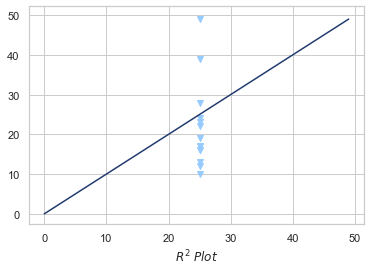

In [41]:
plt.figure()
plt.plot([0,49],[0,49])
plt.scatter(result[0],result[1],color='#97CBFF',marker='v')
plt.xlabel('$R^2\;Plot$')
# pd.DataFrame({'mse@best-alpha':score[0],'r2@best-alpha':score[1]})
# pd.DataFrame({'pred@best-alpha-fold':result[0],'true@best-alpha-fold':result[1]})